<a href="https://colab.research.google.com/github/UlviDemirsoy/finetuning-embeddings-word2vec/blob/main/NeuralNetworkProject_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
#abdüllatif köksalın embeddingleri
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.optim as optim
import torch.nn as nn
from IPython import display


from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/trmodel', binary=True)
type(word_vectors)


gensim.models.keyedvectors.KeyedVectors

In [72]:
word_vectors['elma']

array([ 1.54168272e+00, -8.28550816e-01, -5.99804163e-01, -5.43802619e-01,
       -7.25904346e-01,  3.21621835e-01,  1.19583142e+00, -4.79861259e-01,
       -2.11851522e-01,  7.73116887e-01, -9.06277239e-01, -3.93483452e-02,
       -1.26973486e+00,  1.43339324e+00,  1.04530668e+00,  3.95108104e-01,
        7.67355323e-01,  1.52800903e-01, -5.03707349e-01, -1.05555725e+00,
       -7.56491065e-01, -6.52643219e-02, -5.36817638e-03,  5.53559959e-01,
       -1.61778480e-01,  6.35086298e-01,  8.12060535e-01, -2.79932708e-01,
       -8.12693611e-02,  3.84379253e-02,  4.85552251e-02,  3.20792317e-01,
        1.16494976e-01, -5.62642395e-01,  1.05040038e+00, -2.55720615e-01,
       -1.54870212e-01, -2.98601127e+00, -8.01358745e-03, -3.41691792e-01,
        3.17850441e-01, -1.36190625e-02,  1.52950883e+00,  2.82555342e-01,
        3.22910920e-02,  9.29487109e-01,  2.20093936e-01, -2.52426773e-01,
       -1.47933793e+00,  1.71588380e-02, -1.11571920e+00, -7.25664616e-01,
       -4.51164663e-01, -

In [ ]:
indexedwords=word_vectors.index_to_key
#print(words)

vectors_array = np.zeros((len(word_vectors), word_vectors.vector_size))
for i, word in enumerate(word_vectors.index_to_key):
   # print(word, word_vectors[word])
    vectors_array[i] = word_vectors[word]

# Now vectors_array contains the vectors for each word
print(len(vectors_array))



412457


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
print(type(vectors_array))
vectors_array.shape

<class 'numpy.ndarray'>


(412457, 400)

In [105]:

class AE(nn.Module):
    def __init__(self, n_features, n_hidden):
        super(AE, self).__init__()
        # Encoder layers
        self.encoder_layer1 = nn.Linear(n_features, 200)
        self.encoder_layer2 = nn.Linear(200, 100)
        self.encoder_layer3 = nn.Linear(100, n_hidden)

        # Decoder layers
        self.decoder_layer1 = nn.Linear(n_hidden, 100)
        self.decoder_layer2 = nn.Linear(100, 200)
        self.decoder_layer3 = nn.Linear(200, n_features)

        self.activation = nn.Tanh()
        self.output_activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)


    def encode(self, x):
        x = self.activation(self.encoder_layer1(x))
        x = self.dropout(x)
        x = self.activation(self.encoder_layer2(x))
        x = self.dropout(x)
        encoded = self.activation(self.encoder_layer3(x))
        return encoded

    def decode(self, x):
        x = self.activation(self.decoder_layer1(x))
        x = self.dropout(x)
        x = self.activation(self.decoder_layer2(x))
        x = self.dropout(x)
        decoded = self.output_activation(self.decoder_layer3(x))
        return decoded

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [106]:
from torch.utils.data import TensorDataset, DataLoader, random_split

x_train_tensor = torch.from_numpy(vectors_array).float().to(device)
y_train_tensor = torch.from_numpy(vectors_array).float().to(device)

# Define the proportion of data for training and testing (e.g., 80% training, 20% testing)
train_ratio = 1
train_size = int(train_ratio * len(x_train_tensor))
test_size = len(x_train_tensor) - train_size

# Use random_split to create training and testing datasets
train_dataset, test_dataset = random_split(x_train_tensor, [train_size, test_size])

# Create DataLoader for training and testing datasets if needed
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

learning_rate = 1e-3 # alpha

ae = AE(400, 40)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ae.to(device)

criterion = nn.MSELoss() # (x-y)^2
optimizer = torch.optim.Adam(ae.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-8)
n_epoch = 50
losses = []

In [107]:
for epoch in range(n_epoch):
    running_loss = 0.0
    for data in train_loader:
        inputs = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ae(inputs)
        loss = criterion(outputs, inputs)  # MSE loss between input and reconstructed output

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{n_epoch}], Loss: {running_loss / len(train_loader)}")

Epoch [1/50], Loss: 0.039385339171248986
Epoch [2/50], Loss: 0.03677002534677018
Epoch [3/50], Loss: 0.03647530065022095
Epoch [4/50], Loss: 0.03641243813277474
Epoch [5/50], Loss: 0.03635026214103545
Epoch [6/50], Loss: 0.03633959996733565
Epoch [7/50], Loss: 0.03632165861336824
Epoch [8/50], Loss: 0.03630791315647124
Epoch [9/50], Loss: 0.03629006613184589
Epoch [10/50], Loss: 0.03626887865420015
Epoch [11/50], Loss: 0.03628643275361055
Epoch [12/50], Loss: 0.036275598010228526
Epoch [13/50], Loss: 0.036255369854919964
Epoch [14/50], Loss: 0.036247985576170844
Epoch [15/50], Loss: 0.03625661088500366
Epoch [16/50], Loss: 0.03625062745406521
Epoch [17/50], Loss: 0.03626230729295509
Epoch [18/50], Loss: 0.03624081243726219
Epoch [19/50], Loss: 0.03624388418407653
Epoch [20/50], Loss: 0.036229415928422666
Epoch [21/50], Loss: 0.036218813789208826
Epoch [22/50], Loss: 0.03621277042084533
Epoch [23/50], Loss: 0.03620726168248109
Epoch [24/50], Loss: 0.03619495198759193
Epoch [25/50], Loss

# AutoEncoder Performance

First we pick random words (e.g. 10) and calculate the cosine similarity between each one of them.

So for a list of `['elma', 'armut', 'portakal']` we will have:
  
*   `cosine_similarity('elma', 'armut') `

*   `cosine_similarity('elma', 'portakal') `

*   `cosine_similarity('armut', 'portakal')`

We do this to have different cosine similarity performances between random samples. We do this calculation for both **original vectors (with dimension 400)** and the **encoded vectors (with dimension 40)**, adding them to `original_cos_similarities` and `encoded_cos_similarities`.

In [112]:
import random
ae.eval()
subset_words = random.sample(list(word_vectors.index_to_key), 10)

subset_words = ['elma', 'armut', 'süt', 'şeker', 'tuz', 'karabiber', 'köpek', 'sosyoloji', 'keser', 'kıyma', 'dana', 'pelerin']


word_embeddings_400d = [word_vectors[word] for word in subset_words]

word_embeddings_400d = torch.tensor(word_embeddings_400d, dtype=torch.float32)

# Encode all word embeddings using the autoencoder
encoded_word_embeddings = []
for embedding in word_embeddings_400d:
    embedding = embedding.unsqueeze(0).cuda()
    with torch.no_grad():
      encoded_embedding = ae.encode(embedding)
    encoded_word_embeddings.append(encoded_embedding.squeeze(0))

encoded_word_embeddings = torch.stack(encoded_word_embeddings)

# Compare original cosi and embedded cosi
original_cos_similarities = []
encoded_cos_similarities = []
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
for i in range(len(subset_words)):
    for j in range(i + 1, len(subset_words)):
        original_similarity = cosi(word_embeddings_400d[i].unsqueeze(0), word_embeddings_400d[j].unsqueeze(0)).item()
        original_cos_similarities.append(original_similarity)

        encoded_similarity = cosi(encoded_word_embeddings[i].unsqueeze(0), encoded_word_embeddings[j].unsqueeze(0)).item()
        encoded_cos_similarities.append(encoded_similarity)


We will then check the **mean cos similarities** for both of the cos similarities (encoded and original).   What we want to see is how big the difference is.

In [113]:

original_cos_similarities = np.array(original_cos_similarities)
encoded_cos_similarities = np.array(encoded_cos_similarities)
mean_original_similarity = np.mean(original_cos_similarities)
mean_encoded_similarity = np.mean(encoded_cos_similarities)
print(f"Mean cosine similarity in original space: {mean_original_similarity}")
print(f"Mean cosine similarity in encoded space: {mean_encoded_similarity}")

Mean cosine similarity in original space: 0.2833993813926072
Mean cosine similarity in encoded space: 0.7704421512105248


Finaly we will plot how the different word

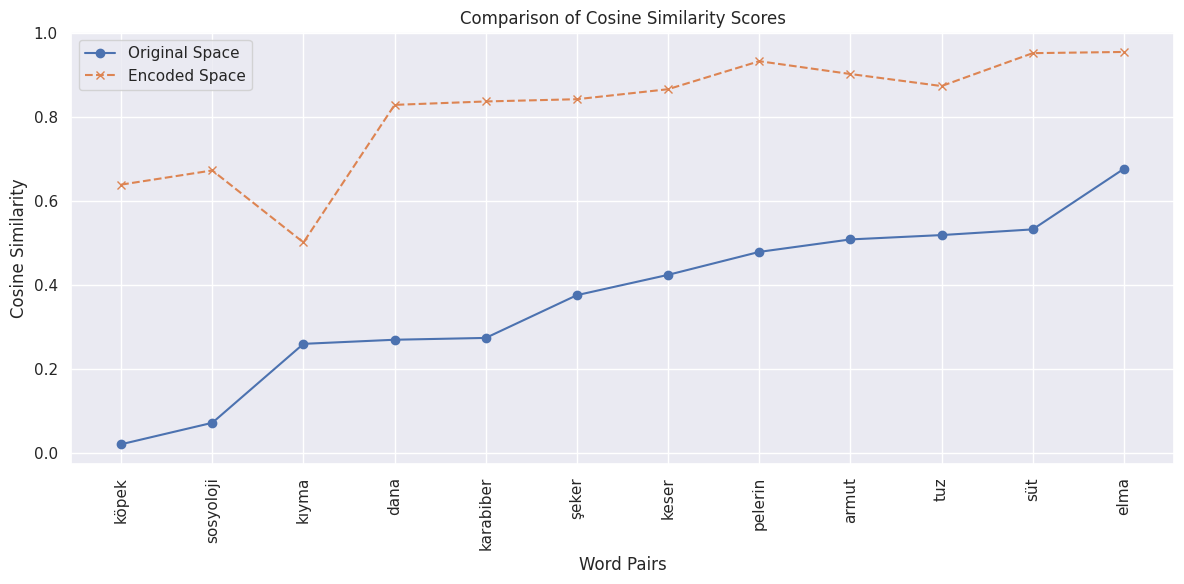

In [114]:
import matplotlib.pyplot as plt


sorted_data = sorted(zip(subset_words, original_cos_similarities, encoded_cos_similarities), key=lambda x: x[1])
sorted_word_pairs, sorted_original_cos_similarities, sorted_encoded_cos_similarities = zip(*sorted_data)

plt.figure(figsize=(12, 6))
plt.plot(sorted_original_cos_similarities, label='Original Space', marker='o', linestyle='-')
plt.plot(sorted_encoded_cos_similarities, label='Encoded Space', marker='x', linestyle='--')

plt.title('Comparison of Cosine Similarity Scores')
plt.xlabel('Word Pairs')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)

plt.xticks(ticks=np.arange(len(sorted_word_pairs)), labels=[f"{pair}" for pair in sorted_word_pairs], rotation=90)
plt.tight_layout()

plt.show()


In [115]:

word1 = (torch.tensor(word_vectors['tükürük'], device="cuda")).unsqueeze(0)
word2 =(torch.tensor(word_vectors['çorba'], device="cuda")).unsqueeze(0)
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
output = cosi(word1, word2)
print("Cosine Similarity of high dimension embeddings", output.item() )



testembedding = ae.encode(word1)
testembedding2 = ae.encode(word2)
# print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of low dim embeddings", output.item() )


Cosine Similarity of high dimension embeddings 0.552217960357666
Cosine Similarity of low dim embeddings 0.9249794483184814


In [116]:
print(device)

cuda


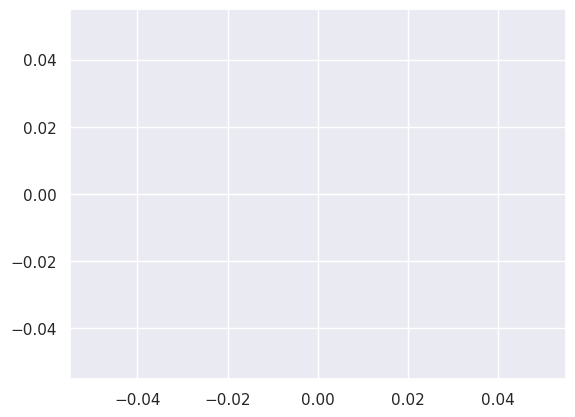

In [117]:
plt.plot(losses)

In [118]:
torch.save(ae, '/content/drive/MyDrive/autoencodermodel.pt')

In [119]:
model = torch.load('/content/drive/MyDrive/autoencodermodel.pt')

In [120]:
model.parameters()

<generator object Module.parameters at 0x7fb8f43129d0>

In [121]:
lowerdimensionembeddings = ae.encode(x_train_tensor)
print(lowerdimensionembeddings.shape)


torch.Size([412457, 40])


In [122]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [123]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("mertbozkurt/llama2-TR-recipe")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [124]:
import string
from nltk.corpus import stopwords

regular_punct = list(string.punctuation)

def remove_punctuation(text,punct_list):
  for punc in punct_list:
      if punc in text:
          text = text.replace(punc, ' ')
  return text.strip()


stopWords = set(stopwords.words('turkish'))
wordsFiltered = []
numerics_removed_words = []
embedding_test = []
counter = 0
for text_dict in dataset["train"]:
  text = text_dict["text"]
  clean_text = remove_punctuation(text, regular_punct)
  words = word_tokenize(clean_text.lower())
  for w in words:
      if w in stopWords:
          continue
      elif not w.isnumeric():
        numerics_removed_words.append(w)
        if counter < 100:
          embedding_test.append(w)
        counter += 1

In [125]:
#yeni gelen kelimeleri bulup random vector initialize edilir

setindextedword = set(indexedwords)
new_words = set(numerics_removed_words)
difference = list(new_words.difference(setindextedword))
print(difference)
print(len(difference))

['mühürlemesidenir', 'yerleştirirseniz', 'salatasını', 'pişip', 'edein', 'bisküvilerden', 'getirmenize', 'kürdr', 'muffinler', 'haşlanmasına', 'irmiklerin', 'kadayıfların', 'çıkartıktan', 'bisküviye', 'serpiştirerek', 'yumurtaalabildiği', 'şantii̇steğe', 'kasedeki', 'parçalamamak', 'beğendiğiyi', 'cevizi1', 'çıtırlaşırken', 'patlıcanları', 'soyulacaklardır', 'çıtırlığını', 'şantiüzeri', 'helvasında', 'yağzsız', 'pandispanyayı', 'eğerkıymalı', 'zerdeçallı', 'mişoriz', 'hamurlarada', 'pastahindistan', 'kabaracaktır', 'eridiğini', 'saplamayın', 'çukurlaştırın', 'fansız', 'cezveyi', 'tüketmediğiniz', 'beyazına', 'ekmeklere', 'rulolarını', 'tariflerimiz', 'mezgidin', 'yemeklerköfteli', 'pişiler', 'sürdüğünüz', 'kemalpaşalı', 'dinlenirse', 'yoğurtlaması', 'püresine', 'lavaştan', 'herbirini', 'piştikçe', 'pişicektir', 'kuruysa', 'pastadamla', 'inceltildiğinden', 'kırığının', 'yağlamayın', 'koyulmuyor', 'mezesini', 'dokunduğunuzda', 'soymayabilirsiniz', 'tarifimizdeki', 'koparabilirsiniz', 'sa

In [127]:
randomembeddings = np.random.rand(len(difference), 40)

copystore = np.copy(lowerdimensionembeddings.cpu().detach().numpy())
for w in difference:
  indexedwords.append(w)

 # lowerdimensionembeddings = np.concatenate((lowerdimensionembeddings, np.random.rand(40)), axis=0)
copystore = np.vstack([copystore, randomembeddings])

In [129]:
print(len(indexedwords), len(copystore))

417057 417057


In [130]:
#fine tune embeddings with new dataset

import pandas as pd

id2tok = dict(enumerate(indexedwords))
tok2id = {token: id for id, token in id2tok.items()}

print(type(tok2id))
#print(tok2id)


data = {'input1': [], 'input2': [], 'output': []}

reverse_data = {'input1': [], 'input2': [], 'output': []}
numerics_removed_words

for i in range(len(numerics_removed_words)-1):
  data['input1'].append(numerics_removed_words[i])
  data['input2'].append(numerics_removed_words[i+1])
  data['output'].append(1)


for i in range(len(numerics_removed_words)-1,1,-1):
  reverse_data['input1'].append(numerics_removed_words[i])
  reverse_data['input2'].append(numerics_removed_words[i-1])
  reverse_data['output'].append(1)

#print("validen",data[:,:-1])
df_data = pd.DataFrame(data)
#df_data
df_reverse = pd.DataFrame(reverse_data)
#df_reverse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

print("tok2idget",tok2id.get)
class data_set(Dataset):
  def __init__(self, data):
    self.X = np.vectorize(tok2id.get)(data[:,:-1])
    self.y = data[:,-1]
  def __len__(self):
    return len(self.X)
  def getx(self):
    return self.X
  def __getitem__(self, index):
    return self.X[index], self.y[index]


dataset = data_set(pd.concat([df_data, df_reverse], ignore_index=True).values)



trainset = dataset


<class 'dict'>
tok2idget <built-in method get of dict object at 0x7fb7d6cffd00>


In [131]:
class Word2Vec2(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(copystore))
    self.embedding.requires_grad = True

  def forward(self, X_batch):
    U = self.embedding(X_batch[:,0])
    V = self.embedding(X_batch[:,1])

    output = torch.sigmoid(torch.sum(torch.mul(U, V), 1))
    return output



In [132]:
len(torch.FloatTensor(copystore))

417057

In [133]:
dataloader = DataLoader(trainset, 1024, shuffle=True)

for i, (batch_X, batch_y) in enumerate(dataloader):
  print(i, batch_X[:,0],batch_X[:,1], batch_y)
  if i >= 2:
    break

0 tensor([ 18270,    118,    166,  ...,  51218,   4970, 416725]) tensor([413168, 416264,  15930,  ..., 413105,     38,     16]) tensor([1, 1, 1,  ..., 1, 1, 1])
1 tensor([ 13775,  13250,   4970,  ..., 416239,   6840,  31328]) tensor([118962, 413070,  35789,  ...,    263,   5514, 414291]) tensor([1, 1, 1,  ..., 1, 1, 1])
2 tensor([180135,     35,  37244,  ...,  28781,    187,     94]) tensor([  1204, 416224,   4538,  ...,    172,    243,    118]) tensor([1, 1, 1,  ..., 1, 1, 1])


In [134]:
type(torch.FloatTensor(vectors_array))

torch.Tensor

In [135]:
from itertools import chain
from collections import Counter

dim_size = 40
embed_size = 5

model = Word2Vec2()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

LR = 1e-1
EPOCHS = 200
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

from tqdm import tqdm # For progress bars
from IPython import display

running_loss = []
for epoch in tqdm(range(EPOCHS)):
  epoch_loss = 0
  for i, (batch_X, batch_y) in enumerate(dataloader):
    optimizer.zero_grad()
    # X_batch is (i,j) index must be int
    X_batch = batch_X.type(torch.int).to(device)
    # y_batch must be float
    y_batch = batch_y.type(torch.float32).to(device)
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    epoch_loss += loss.item()
    loss.requires_grad = True
    loss.backward()
    optimizer.step()
  epoch_loss /= len(dataloader)
  running_loss.append(epoch_loss)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')
  display.clear_output(wait=True)

100%|██████████| 200/200 [45:41<00:00, 13.71s/it]


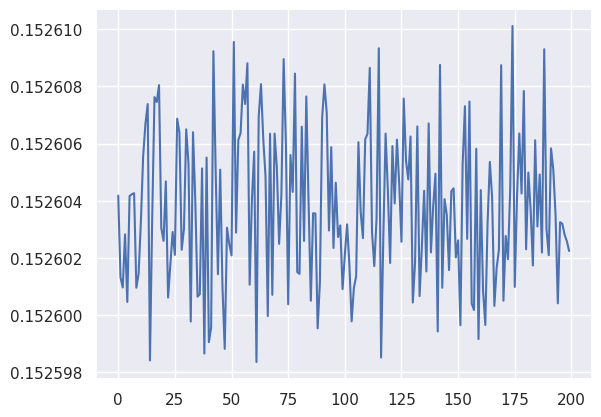

In [136]:
plt.plot(running_loss)

In [137]:
torch.save(model, '/content/drive/MyDrive/word2vecmodel.pt')

In [138]:
test_embeddings = [
    ['biber', 'dolması'],
    ['dana', 'kıyma'],
    ['trakya', 'kapama'],
    ['fırında', 'kuzu'],
    ['nohut', 'yemeği'],
    ['soslu', 'tavuk'],
    ['toz', 'şeker'],
    ['cevizli', 'kek'],
    ['tuz', 'kimyon'],
    ['tuz', 'karabiber'],
    ['tas', 'kebabı'],
]

In [139]:

from IPython.display import display, HTML

df = pd.DataFrame({'words': "", 'old embedding': [], 'new embedding': []})
"""
for words in test_embeddings:
  testembedding = None
  testembedding2 = None
  testembedding = model.embedding(torch.tensor((tok2id.get(f"{words[0]}")), device="cpu"))
  testembedding2 = model.embedding(torch.tensor((tok2id.get(f"{word[1]}")), device="cpu"))
  cosi = torch.nn.CosineSimilarity(dim=0)
  output = cosi(testembedding, testembedding2)
  print("Cosine Similarity of new embeddings",output )

  oldembedding = None
  oldembedding = (torch.tensor(word_vectors[f"{words[0]}"], device="cpu"))
  oldembedding2 = (torch.tensor(word_vectors[f"{words[1]}"], device="cpu"))
  output2 = cosi(oldembedding, oldembedding2)
  print("Cosine Similarity of Köksal's embeddings",output2 )

  df.loc[len(df.index)] =  {'words': f"{words[0]} {words[1]}" ,'old embedding': output2, 'new embedding': output}
"""
display(df)


,words,old embedding,new embedding


In [140]:

word1 = (torch.tensor(word_vectors['diş'], device="cuda"))
word2 =(torch.tensor(word_vectors['sarımsak'], device="cuda"))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(word1, word2)
print("Cosine Similarity of high dimension embeddings",output )


testembedding = ae.encode(word1)
testembedding2 = ae.encode(word2)
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of low dim embeddings",output )


Cosine Similarity of high dimension embeddings tensor(0.3861, device='cuda:0')
<class 'torch.Tensor'>
Cosine Similarity of low dim embeddings tensor(0.9159, device='cuda:0', grad_fn=<SumBackward1>)


In [141]:

word1 = (torch.tensor(word_vectors['toz'], device="cuda"))
word2 =(torch.tensor(word_vectors['şeker'], device="cuda"))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(word1, word2)
print("Cosine Similarity of high dimension embeddings",output )



testembedding = ae.encode(word1)
testembedding2 = ae.encode(word2)
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of low dim embeddings",output )


Cosine Similarity of high dimension embeddings tensor(0.4285, device='cuda:0')
<class 'torch.Tensor'>
Cosine Similarity of low dim embeddings tensor(0.7701, device='cuda:0', grad_fn=<SumBackward1>)


In [142]:
word1 = 'biber'
word2 = 'dolması'

testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}



<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9475, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6452, device='cuda:0')


In [143]:
word1 = 'dana'
word2 = 'kıyma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6751, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3915, device='cuda:0')


In [144]:
word1 = 'trakya'
word2 = 'kapama'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.4286, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1048, device='cuda:0')


In [145]:
word1 = 'fırında'
word2 = 'kuzu'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8493, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5269, device='cuda:0')


In [146]:
word1 = 'nohut'
word2 = 'yemek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8103, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4435, device='cuda:0')


In [147]:
word1 = 'sos'
word2 = 'tavuk'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8453, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6097, device='cuda:0')


In [148]:
word1 = 'toz'
word2 = 'şeker'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7701, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4285, device='cuda:0')


In [149]:
word1 = 'cevizli'
word2 = 'kek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8384, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6151, device='cuda:0')


In [150]:
word1 = 'tuz'
word2 = 'kimyon'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8275, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5691, device='cuda:0')


In [151]:
word1 = 'tuz'
word2 = 'karabiber'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8335, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6087, device='cuda:0')


In [152]:
word1 = 'taze'
word2 = 'soğan'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9740, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7526, device='cuda:0')


In [153]:
word1 = 'irmik'
word2 = 'helvası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9327, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8359, device='cuda:0')


In [154]:
word1 = 'sıvı'
word2 = 'yağ'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9218, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6630, device='cuda:0')


In [155]:
word1 = 'bitter'
word2 = 'çikolata'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8421, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3734, device='cuda:0')


In [156]:
word1 = 'bulgur'
word2 = 'çorbası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9487, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8545, device='cuda:0')


In [157]:
word1 = 'domates'
word2 = 'çorbası'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9233, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6739, device='cuda:0')


In [158]:
word1 = 'kırmızı'
word2 = 'lahana'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8246, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2129, device='cuda:0')


In [159]:
word1 = 'bulgur'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9370, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8554, device='cuda:0')


In [160]:
word1 = 'süzme'
word2 = 'yoğurt'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9302, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7943, device='cuda:0')


In [161]:
word1 = 'ton'
word2 = 'balık'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8566, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2968, device='cuda:0')


In [162]:
word1 = 'kuskus'
word2 = 'salata'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9599, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7725, device='cuda:0')


In [163]:
word1 = 'deniz'
word2 = 'börülce'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6388, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0669, device='cuda:0')


In [164]:
word1 = 'ramazan'
word2 = 'pide'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6914, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3455, device='cuda:0')


In [165]:
word1 = 'ekmek'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8190, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6309, device='cuda:0')


In [166]:
word1 = 'patates'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9169, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7516, device='cuda:0')


In [167]:
word1 = 'peynirli'
word2 = 'acuka'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9227, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4063, device='cuda:0')


In [168]:
word1 = 'yufka'
word2 = 'börek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9804, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8551, device='cuda:0')


In [169]:
word1 = 'çöp'
word2 = 'şiş'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9059, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4036, device='cuda:0')


In [170]:
word1 = 'tencere'
word2 = 'kapağı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7845, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2666, device='cuda:0')


In [171]:
word1 = 'izmir'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6545, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1399, device='cuda:0')


In [172]:
word1 = 'taze'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9409, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6825, device='cuda:0')


In [173]:
word1 = 'kapuska'
word2 = 'yemek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6518, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4026, device='cuda:0')


In [174]:
word1 = 'brüksel'
word2 = 'lahana'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5448, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0116, device='cuda:0')


In [175]:
word1 = 'kabaklı'
word2 = 'mücver'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9387, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4801, device='cuda:0')


In [176]:
word1 = 'ıspanak'
word2 = 'yemek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7715, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4381, device='cuda:0')


In [177]:
word1 = 'galeta'
word2 = 'un'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6908, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0123, device='cuda:0')


In [178]:
word1 = 'elma'
word2 = 'dilim'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8020, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4229, device='cuda:0')


In [179]:
word1 = 'patlıcan'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9770, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8369, device='cuda:0')


In [180]:
word1 = 'kabak'
word2 = 'musakka'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8520, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7489, device='cuda:0')


In [181]:
word1 = 'sebze'
word2 = 'kızartma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7780, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5474, device='cuda:0')


In [182]:
word1 = 'sıcak'
word2 = 'su'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9606, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3224, device='cuda:0')


In [183]:
word1 = 'kuru'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9259, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6249, device='cuda:0')


In [184]:
word1 = 'kızgın'
word2 = 'yağ'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6530, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2554, device='cuda:0')


In [185]:
word1 = 'biber'
word2 = 'dolma'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9563, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6685, device='cuda:0')


In [186]:
word1 = 'şark'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7971, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2091, device='cuda:0')


In [187]:
word1 = 'patates'
word2 = 'püre'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8131, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5783, device='cuda:0')


In [188]:
word1 = 'taze'
word2 = 'fasulye'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9409, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6825, device='cuda:0')


In [189]:
word1 = 'çerkez'
word2 = 'çorba'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.5907, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3096, device='cuda:0')


In [190]:
word1 = 'bardakta'
word2 = 'tiramisu'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9948, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.2655, device='cuda:0')


In [191]:
word1 = 'kağıt'
word2 = 'kebabı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8912, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4056, device='cuda:0')


In [192]:
word1 = 'etli'
word2 = 'patlıcan'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9635, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.8285, device='cuda:0')


In [193]:
word1 = 'isveç'
word2 = 'köftesi'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6795, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.0545, device='cuda:0')


In [194]:
word1 = 'çiğ'
word2 = 'köfte'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8771, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6607, device='cuda:0')


In [195]:
word1 = 'diş'
word2 = 'sarımsak'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9159, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3861, device='cuda:0')


In [196]:
word1 = 'bal'
word2 = 'kabağı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8857, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5757, device='cuda:0')


In [197]:
word1 = 'kuru'
word2 = 'üzüm'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.8910, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5373, device='cuda:0')


In [198]:
word1 = 'mısır'
word2 = 'un'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.6534, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.1330, device='cuda:0')


In [199]:
word1 = 'ayva'
word2 = 'tatlı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9065, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.4768, device='cuda:0')


In [200]:
word1 = 'vanilya'
word2 = 'süt'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7855, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5301, device='cuda:0')


In [201]:
word1 = 'ıslak'
word2 = 'kek'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9119, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.3756, device='cuda:0')


In [202]:
word1 = 'kuru'
word2 = 'baklava'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9297, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5204, device='cuda:0')


In [203]:
word1 = 'tahin'
word2 = 'pekmez'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9129, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.7965, device='cuda:0')


In [204]:
word1 = 'ekmek'
word2 = 'kadayıfı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7540, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6094, device='cuda:0')


In [205]:
word1 = 'çilekli'
word2 = 'parfe'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.9878, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.6477, device='cuda:0')


In [206]:
word1 = 'antep'
word2 = 'fıstıklı'
testembedding = model.embedding(torch.tensor((tok2id.get(word1)), device="cuda"))
testembedding2 = model.embedding(torch.tensor((tok2id.get(word2)), device="cuda"))
print(type(testembedding2))
cosi = torch.nn.CosineSimilarity(dim=0)
output = cosi(testembedding, testembedding2)
print("Cosine Similarity of new embeddings",output )

oldembedding = (torch.tensor(word_vectors[word1], device="cuda"))
oldembedding2 = (torch.tensor(word_vectors[word2], device="cuda"))
output2 = cosi(oldembedding, oldembedding2)
print("Cosine Similarity of Köksal's embeddings",output2 )


#df.loc[len(df.index)] =  {'words': f"{word1} {word2}" ,'old embedding': output2, 'new embedding': output}

<class 'torch.Tensor'>
Cosine Similarity of new embeddings tensor(0.7692, device='cuda:0')
Cosine Similarity of Köksal's embeddings tensor(0.5843, device='cuda:0')


In [207]:
print(df.to_markdown())


| words   | old embedding   | new embedding   |
|---------|-----------------|-----------------|
